# Mobility Attention Analysis

**Goal**: Predict next location category from trajectory history using Transformer attention.

This notebook covers:
1. **EDA** — Explore Gowalla and Foursquare datasets
2. **Standard model** — Baseline `TrajectoryTransformer` on group-level categories (18 groups)
3. **Feature model** — `TrajectoryTransformerWithFeatures` (hour, day-of-week, time gap, distance)
4. **Attention analysis** — What the model learns to attend to

Both models use `group_level=True`. Run on both Gowalla (Dallas/Austin) and Foursquare (Washington/Baltimore).

## 1. Setup & Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import config, data, model, train, attention
for mod in [config, data, model, train, attention]:
    importlib.reload(mod)

from config import FOURSQUARE_URL, GOWALLA_URL, CATEGORY_KEYWORDS
from data import prepare_data, load_gowalla_data, load_foursquare_data, auto_categorize
from model import TrajectoryTransformer, TrajectoryTransformerWithFeatures
from train import split_data, train_model
from attention import analyze_attention, get_attention_stats, analyze_by_transition_type

# Set to True to skip training and load saved results
LOAD_SAVED = False

# Placeholders for attention results (populated later)
attn_std_gw = attn_std_fs = attn_feat_gw = attn_feat_fs = None

## 2. Exploratory Data Analysis

In [2]:
# Load raw data
df_foursquare = pd.read_csv(FOURSQUARE_URL)
df_gowalla = pd.read_csv(GOWALLA_URL)

print("FOURSQUARE (Washington/Baltimore):")
print(f"  Shape: {df_foursquare.shape}")
print(f"  Users: {df_foursquare['userid'].nunique()}")
print(f"  Categories: {df_foursquare['spot_categ'].nunique()}")
print(f"  Check-ins per user: {len(df_foursquare) / df_foursquare['userid'].nunique():.1f}")

print("\nGOWALLA (Dallas/Austin):")
print(f"  Shape: {df_gowalla.shape}")
print(f"  Users: {df_gowalla['userid'].nunique()}")
print(f"  Categories: {df_gowalla['spot_categ'].nunique()}")
print(f"  Check-ins per user: {len(df_gowalla) / df_gowalla['userid'].nunique():.1f}")

FOURSQUARE (Washington/Baltimore):
  Shape: (29593, 8)
  Users: 129
  Categories: 355
  Check-ins per user: 229.4

GOWALLA (Dallas/Austin):
  Shape: (684326, 7)
  Users: 2954
  Categories: 405
  Check-ins per user: 231.7


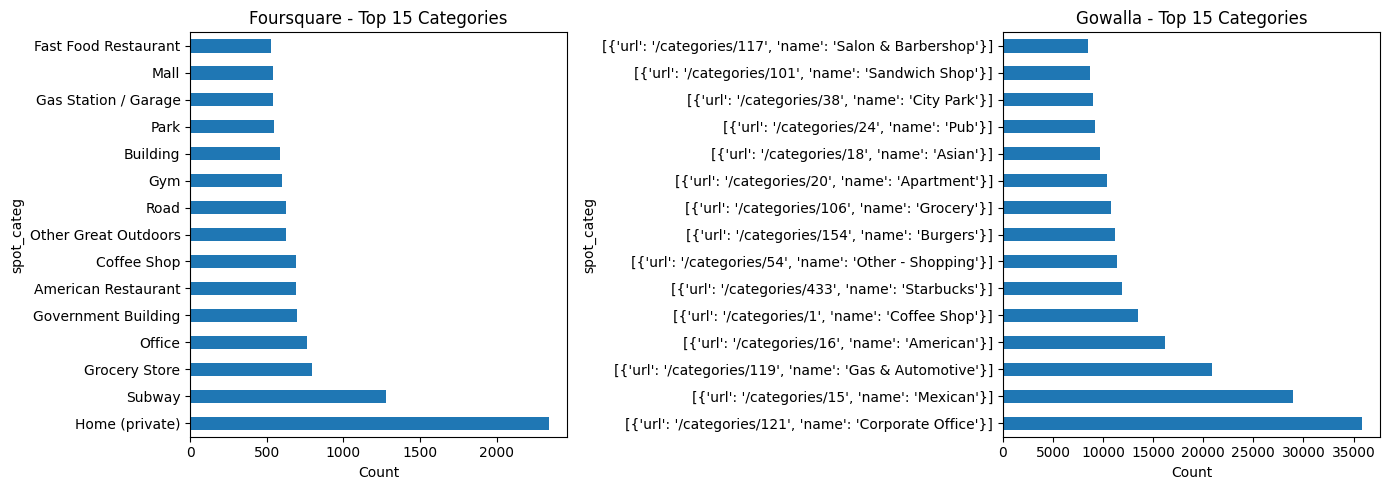

In [3]:
# Top 15 raw categories (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, df) in zip(axes, [('Foursquare', df_foursquare), ('Gowalla', df_gowalla)]):
    top_cats = df['spot_categ'].value_counts().head(15)
    top_cats.plot(kind='barh', ax=ax)
    ax.set_title(f'{name} - Top 15 Categories')
    ax.set_xlabel('Count')

plt.tight_layout()
plt.show()

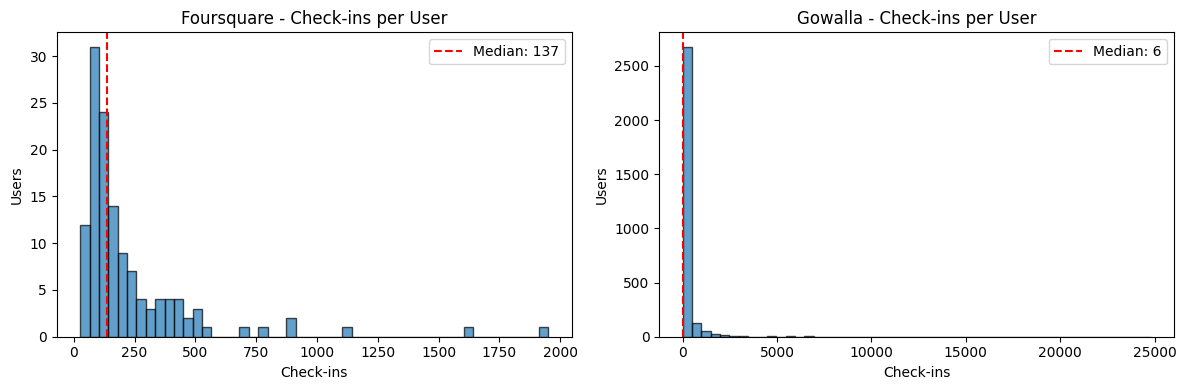

In [4]:
# Check-ins per user distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (name, df) in zip(axes, [('Foursquare', df_foursquare), ('Gowalla', df_gowalla)]):
    checkins_per_user = df.groupby('userid').size()
    ax.hist(checkins_per_user, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(checkins_per_user.median(), color='red', linestyle='--',
               label=f'Median: {checkins_per_user.median():.0f}')
    ax.set_title(f'{name} - Check-ins per User')
    ax.set_xlabel('Check-ins')
    ax.set_ylabel('Users')
    ax.legend()

plt.tight_layout()
plt.show()

Category groups and keywords:
  Food: restaurant, food, mexican, american, asian...
  Coffee/Dessert: coffee, starbucks, dessert, bakery, ice cream...
  Bar/Nightlife: bar, pub, nightlife, lounge, brewery...
  Shopping: shop, store, mall, grocery, market...
  Work: office, corporate, work, coworking, warehouse...
  Home: apartment, home, residential, house, condo...
  Transit: airport, train, bus, station, transit...
  Entertainment: cinema, theater, theatre, movie, museum...
  Outdoors: park, garden, plaza, beach, trail...
  Hotel: hotel, motel, inn, resort, lodging...
  Services: salon, barber, gym, fitness, spa...
  Education: school, university, college, library, campus...
  Zoo/Nature: zoo, aquarium, aviary, reptile, animal...
  Sports: sports, field, court, golf, tennis...
  Culture: historic, landmark, architecture, sculpture, castle...
  Religious: church, temple, mission, place of worship, cemetery...
  Tech: technology...


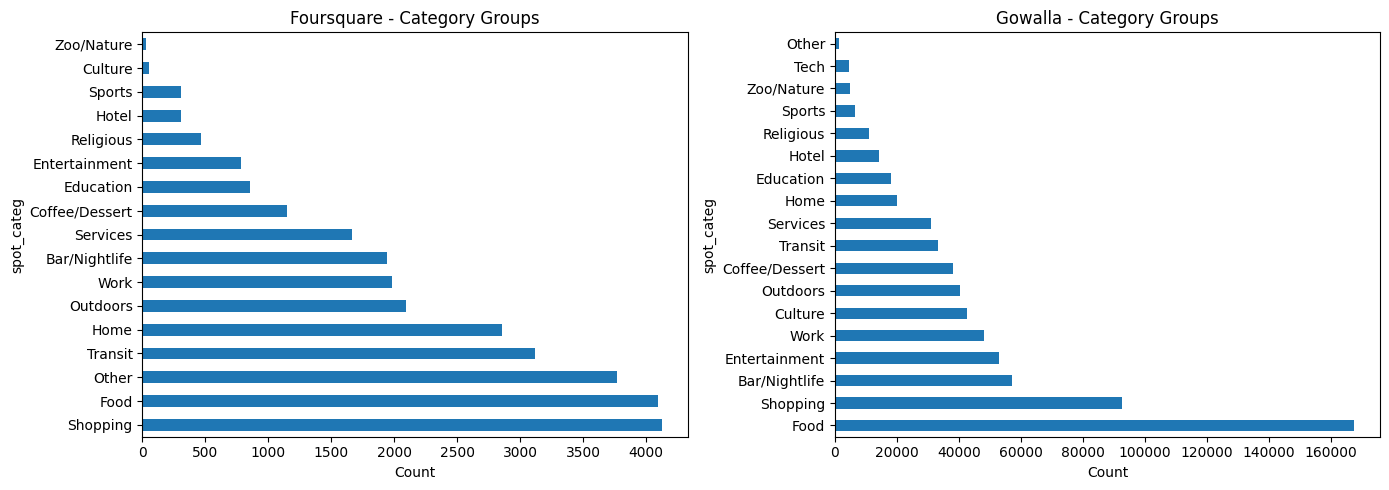

In [5]:
# Category-to-group mapping and group distribution
print("Category groups and keywords:")
for group, keywords in CATEGORY_KEYWORDS.items():
    print(f"  {group}: {', '.join(keywords[:5])}...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, df, cat_col) in zip(axes, [
    ('Foursquare', df_foursquare, 'spot_categ'),
    ('Gowalla', df_gowalla, 'spot_categ')
]):
    groups = df[cat_col].apply(auto_categorize)
    group_counts = groups.value_counts()
    group_counts.plot(kind='barh', ax=ax)
    ax.set_title(f'{name} - Category Groups')
    ax.set_xlabel('Count')

plt.tight_layout()
plt.show()

## 3. Data Preparation

Prepare data with `group_level=True` — maps raw categories to 18 high-level groups (Food, Shopping, etc.).

In [6]:
# Prepare data for standard model (with collapse, no features)
print("Loading Gowalla (group-level, standard)...")
data_gw = prepare_data(dataset="gowalla", group_level=True, include_features=False)
print(f"  Trajectories: {len(data_gw['trajectories'])}, Samples: {len(data_gw['dataset'])}")

print("\nLoading Foursquare (group-level, standard)...")
data_fs = prepare_data(dataset="foursquare", group_level=True, include_features=False)
print(f"  Trajectories: {len(data_fs['trajectories'])}, Samples: {len(data_fs['dataset'])}")

Loading Gowalla (group-level, standard)...
  Trajectories: 66620, Samples: 946341

Loading Foursquare (group-level, standard)...
  Trajectories: 2256, Samples: 31725


In [7]:
# Trajectory stats and samples
for name, data in [('Gowalla', data_gw), ('Foursquare', data_fs)]:
    trajs = data['trajectories']
    lengths = [len(t) for t in trajs]
    print(f"\n{name}:")
    print(f"  Trajectories: {len(trajs)}")
    print(f"  Users: {len(set(data['user_ids']))}")
    print(f"  Vocab: {list(data['vocab'].keys())}")
    print(f"  Length: min={min(lengths)}, max={max(lengths)}, mean={np.mean(lengths):.1f}")
    print(f"  Sample: {trajs[0][:8]}...")


Gowalla:
  Trajectories: 66620
  Users: 1071
  Vocab: ['Bar/Nightlife', 'Coffee/Dessert', 'Culture', 'Education', 'Entertainment', 'Food', 'Home', 'Hotel', 'Other', 'Outdoors', 'Religious', 'Services', 'Shopping', 'Sports', 'Tech', 'Transit', 'Work', 'Zoo/Nature', '[PAD]']
  Length: min=3, max=20, mean=15.2
  Sample: ['Outdoors', 'Work', 'Food', 'Work', 'Coffee/Dessert', 'Bar/Nightlife', 'Work', 'Bar/Nightlife']...

Foursquare:
  Trajectories: 2256
  Users: 129
  Vocab: ['Bar/Nightlife', 'Coffee/Dessert', 'Education', 'Entertainment', 'Food', 'Home', 'Hotel', 'Other', 'Outdoors', 'Religious', 'Services', 'Shopping', 'Sports', 'Transit', 'Work', '[PAD]']
  Length: min=3, max=20, mean=15.1
  Sample: ['Shopping', 'Coffee/Dessert', 'Work', 'Coffee/Dessert', 'Work', 'Other', 'Coffee/Dessert', 'Work']...


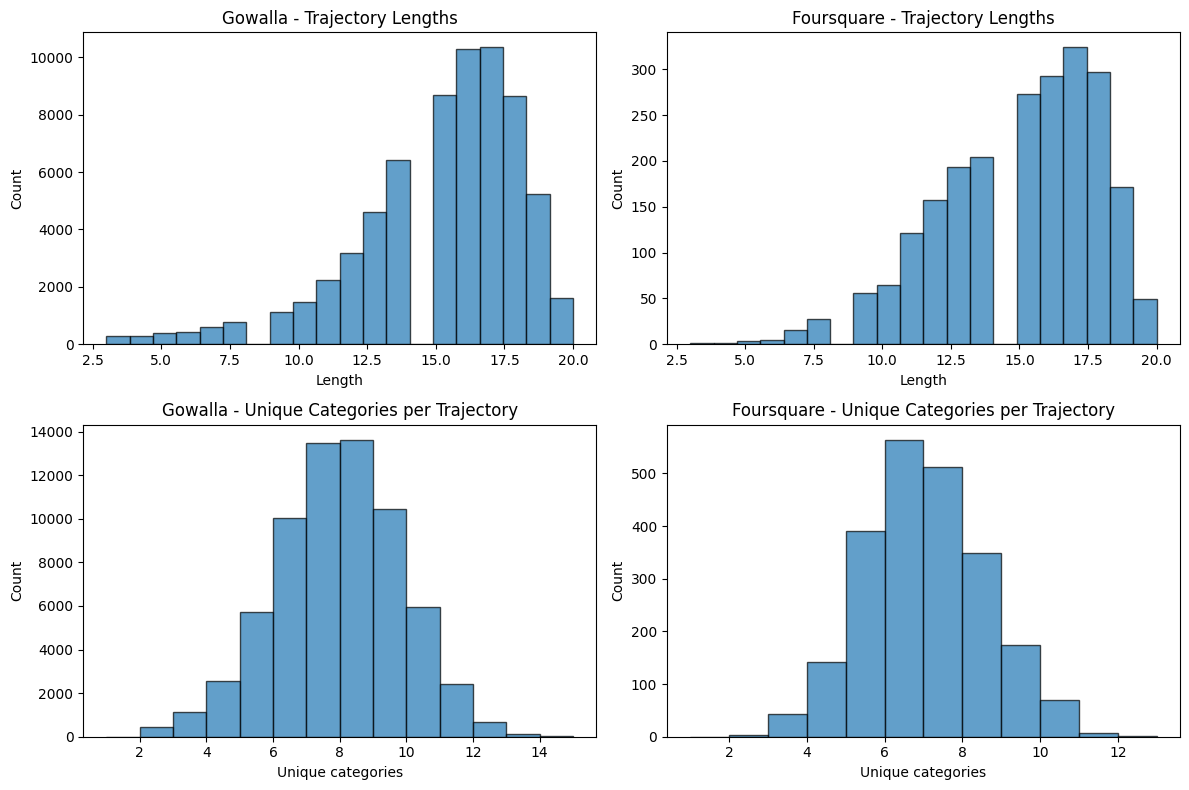

In [8]:
# Trajectory length distribution + unique categories per trajectory
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for col, (name, data) in enumerate([('Gowalla', data_gw), ('Foursquare', data_fs)]):
    trajs = data['trajectories']
    lengths = [len(t) for t in trajs]
    uniques = [len(set(t)) for t in trajs]

    axes[0, col].hist(lengths, bins=20, edgecolor='black', alpha=0.7)
    axes[0, col].set_title(f'{name} - Trajectory Lengths')
    axes[0, col].set_xlabel('Length')
    axes[0, col].set_ylabel('Count')

    axes[1, col].hist(uniques, bins=range(1, max(uniques) + 2), edgecolor='black', alpha=0.7)
    axes[1, col].set_title(f'{name} - Unique Categories per Trajectory')
    axes[1, col].set_xlabel('Unique categories')
    axes[1, col].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 4. Standard Model (Baseline)

`TrajectoryTransformer` — predicts next group from category history only (no temporal/spatial features).

In [9]:
# Split data for both datasets
print("=== Gowalla ===")
train_loader_gw, test_loader_gw, train_ds_gw, test_ds_gw = split_data(
    data_gw['trajectories'], data_gw['user_ids'], data_gw['vocab']
)

print("\n=== Foursquare ===")
train_loader_fs, test_loader_fs, train_ds_fs, test_ds_fs = split_data(
    data_fs['trajectories'], data_fs['user_ids'], data_fs['vocab']
)

=== Gowalla ===
Stratified split by user activity:
  Train users: mean=62.7 trajs/user, median=13.0
  Test users:  mean=60.4 trajs/user, median=13.0
Users: 856 train, 215 test
Trajectories: 53632 train, 12988 test

=== Foursquare ===
Stratified split by user activity:
  Train users: mean=18.2 trajs/user, median=11.0
  Test users:  mean=15.0 trajs/user, median=9.5
Users: 101 train, 28 test
Trajectories: 1836 train, 420 test


In [10]:
# Create standard models
model_std_gw = TrajectoryTransformer(len(data_gw['vocab']))
model_std_fs = TrajectoryTransformer(len(data_fs['vocab']))

print(f"Gowalla model params: {sum(p.numel() for p in model_std_gw.parameters()):,}")
print(f"Foursquare model params: {sum(p.numel() for p in model_std_fs.parameters()):,}")

Gowalla model params: 565,970
Foursquare model params: 565,583


In [11]:
if not LOAD_SAVED:
    # Train Gowalla standard model
    print("=" * 60)
    print("TRAINING: Standard Transformer — Gowalla")
    print("=" * 60)
    history_std_gw = train_model(
        model_std_gw, train_loader_gw, data_gw['vocab'],
        epochs=15, print_every=5, test_loader=test_loader_gw
    )

TRAINING: Standard Transformer — Gowalla
Using device: cpu
Using hard loss
Epoch 5/15 - Loss: 2.2903 - Train: 27.96% - Test: 27.87%
Epoch 10/15 - Loss: 2.2818 - Train: 28.07% - Test: 27.82%
Epoch 15/15 - Loss: 2.2769 - Train: 28.19% - Test: 28.12%


In [12]:
if not LOAD_SAVED:
    # Train Foursquare standard model
    print("=" * 60)
    print("TRAINING: Standard Transformer — Foursquare")
    print("=" * 60)
    history_std_fs = train_model(
        model_std_fs, train_loader_fs, data_fs['vocab'],
        epochs=15, print_every=5, test_loader=test_loader_fs
    )

TRAINING: Standard Transformer — Foursquare
Using device: cpu
Using hard loss
Epoch 5/15 - Loss: 2.1064 - Train: 27.75% - Test: 22.55%
Epoch 10/15 - Loss: 2.0204 - Train: 30.24% - Test: 21.85%
Epoch 15/15 - Loss: 1.9150 - Train: 33.60% - Test: 20.81%


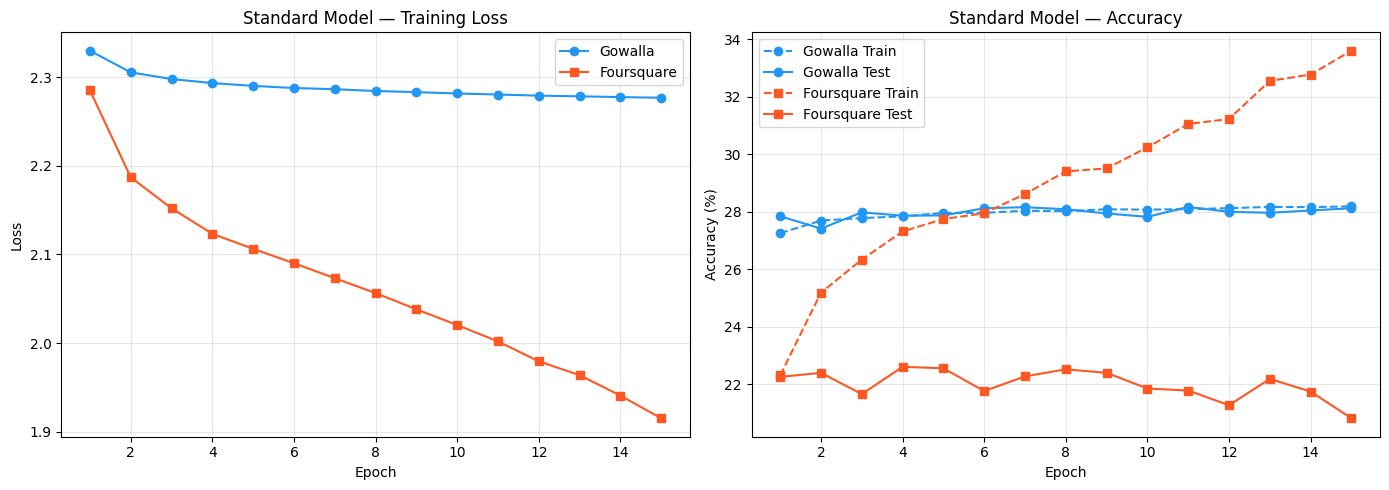

In [13]:
if not LOAD_SAVED:
    # Training curves — standard models
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, 16)

    # Loss
    axes[0].plot(epochs_range, history_std_gw['loss'], 'o-', label='Gowalla', color='#2196F3')
    axes[0].plot(epochs_range, history_std_fs['loss'], 's-', label='Foursquare', color='#FF5722')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Standard Model — Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(epochs_range, [a*100 for a in history_std_gw['accuracy']], 'o--', label='Gowalla Train', color='#2196F3')
    axes[1].plot(epochs_range, [a*100 for a in history_std_gw['test_accuracy']], 'o-', label='Gowalla Test', color='#2196F3')
    axes[1].plot(epochs_range, [a*100 for a in history_std_fs['accuracy']], 's--', label='Foursquare Train', color='#FF5722')
    axes[1].plot(epochs_range, [a*100 for a in history_std_fs['test_accuracy']], 's-', label='Foursquare Test', color='#FF5722')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Standard Model — Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [14]:
# Baseline analysis — most-frequent class and random
from collections import Counter

for name, data, test_ds in [('Gowalla', data_gw, test_ds_gw), ('Foursquare', data_fs, test_ds_fs)]:
    # Count target distribution in test set
    targets = [sample[1] if len(sample) == 2 else sample[5] for sample in test_ds]
    target_counts = Counter(targets)
    most_common_count = target_counts.most_common(1)[0][1]
    total = len(targets)
    n_classes = len(data['vocab']) - 1  # exclude PAD

    print(f"\n{name}:")
    print(f"  Random baseline: {100/n_classes:.1f}%")
    print(f"  Most-frequent baseline: {100*most_common_count/total:.1f}%")
    print(f"  Number of classes: {n_classes}")


Gowalla:
  Random baseline: 5.6%
  Most-frequent baseline: 21.9%
  Number of classes: 18

Foursquare:
  Random baseline: 6.7%
  Most-frequent baseline: 15.9%
  Number of classes: 15


## 5. Feature-Augmented Model (V1)

`TrajectoryTransformerWithFeatures` adds four temporal/spatial features to each position:
- **Hour of day** (0-23) — embedded
- **Day of week** (0-6) — embedded
- **Time gap** — hours since previous check-in (normalized, capped at 168h)
- **Distance** — km from previous check-in (normalized, capped at 100km)

These are concatenated with the category embedding and projected back to `embed_dim` before the transformer.

Both models use the same collapsed trajectories (consecutive duplicates removed). For the feature model, temporal/spatial features are kept from the **first occurrence** of each consecutive run, ensuring a fair comparison.

In [15]:
# Prepare feature data for both datasets
print("Loading Gowalla (group-level, with features)...")
data_feat_gw = prepare_data(dataset="gowalla", group_level=True, include_features=True)
print(f"  Trajectories: {len(data_feat_gw['trajectories'])}, Samples: {len(data_feat_gw['dataset'])}")

print("\nLoading Foursquare (group-level, with features)...")
data_feat_fs = prepare_data(dataset="foursquare", group_level=True, include_features=True)
print(f"  Trajectories: {len(data_feat_fs['trajectories'])}, Samples: {len(data_feat_fs['dataset'])}")

Loading Gowalla (group-level, with features)...
  Trajectories: 66620, Samples: 946341

Loading Foursquare (group-level, with features)...
  Trajectories: 2256, Samples: 31725


In [16]:
# Feature examples — sample time gap and distance distributions
for name, data in [('Gowalla', data_feat_gw), ('Foursquare', data_feat_fs)]:
    feats = data['feature_trajs']
    all_tgaps = [g for f in feats for g in f['tgaps'] if g > 0]
    all_dists = [d for f in feats for d in f['dists'] if d > 0]
    print(f"\n{name} features:")
    print(f"  Time gaps (normalized): mean={np.mean(all_tgaps):.3f}, median={np.median(all_tgaps):.3f}")
    print(f"  Distances (normalized): mean={np.mean(all_dists):.3f}, median={np.median(all_dists):.3f}")


Gowalla features:
  Time gaps (normalized): mean=0.061, median=0.001
  Distances (normalized): mean=0.058, median=0.010

Foursquare features:
  Time gaps (normalized): mean=0.233, median=0.082
  Distances (normalized): mean=0.143, median=0.071


In [17]:
# Split feature data
print("=== Gowalla (features) ===")
train_loader_feat_gw, test_loader_feat_gw, train_ds_feat_gw, test_ds_feat_gw = split_data(
    data_feat_gw['trajectories'], data_feat_gw['user_ids'], data_feat_gw['vocab'],
    feature_trajs=data_feat_gw['feature_trajs']
)

print("\n=== Foursquare (features) ===")
train_loader_feat_fs, test_loader_feat_fs, train_ds_feat_fs, test_ds_feat_fs = split_data(
    data_feat_fs['trajectories'], data_feat_fs['user_ids'], data_feat_fs['vocab'],
    feature_trajs=data_feat_fs['feature_trajs']
)

=== Gowalla (features) ===
Stratified split by user activity:
  Train users: mean=62.7 trajs/user, median=13.0
  Test users:  mean=60.4 trajs/user, median=13.0
Users: 856 train, 215 test
Trajectories: 53632 train, 12988 test

=== Foursquare (features) ===
Stratified split by user activity:
  Train users: mean=18.2 trajs/user, median=11.0
  Test users:  mean=15.0 trajs/user, median=9.5
Users: 101 train, 28 test
Trajectories: 1836 train, 420 test


In [18]:
53736+13008

66744

In [19]:
# Create feature models
model_feat_gw = TrajectoryTransformerWithFeatures(len(data_feat_gw['vocab']))
model_feat_fs = TrajectoryTransformerWithFeatures(len(data_feat_fs['vocab']))

print(f"Gowalla feature model params: {sum(p.numel() for p in model_feat_gw.parameters()):,}")
print(f"Foursquare feature model params: {sum(p.numel() for p in model_feat_fs.parameters()):,}")

Gowalla feature model params: 571,246
Foursquare feature model params: 570,859


In [20]:
if not LOAD_SAVED:
    # Train Gowalla feature model
    print("=" * 60)
    print("TRAINING: Feature Transformer — Gowalla")
    print("=" * 60)
    history_feat_gw = train_model(
        model_feat_gw, train_loader_feat_gw, data_feat_gw['vocab'],
        epochs=15, print_every=5, test_loader=test_loader_feat_gw
    )

TRAINING: Feature Transformer — Gowalla
Using device: cpu
Using hard loss
Epoch 5/15 - Loss: 2.2719 - Train: 28.46% - Test: 28.47%
Epoch 10/15 - Loss: 2.2579 - Train: 28.81% - Test: 28.49%
Epoch 15/15 - Loss: 2.2495 - Train: 28.98% - Test: 28.52%


In [21]:
if not LOAD_SAVED:
    # Train Foursquare feature model
    print("=" * 60)
    print("TRAINING: Feature Transformer — Foursquare")
    print("=" * 60)
    history_feat_fs = train_model(
        model_feat_fs, train_loader_feat_fs, data_feat_fs['vocab'],
        epochs=15, print_every=5, test_loader=test_loader_feat_fs
    )

TRAINING: Feature Transformer — Foursquare
Using device: cpu
Using hard loss
Epoch 5/15 - Loss: 2.0796 - Train: 28.80% - Test: 22.30%
Epoch 10/15 - Loss: 1.8841 - Train: 36.05% - Test: 21.34%
Epoch 15/15 - Loss: 1.5710 - Train: 46.27% - Test: 20.67%


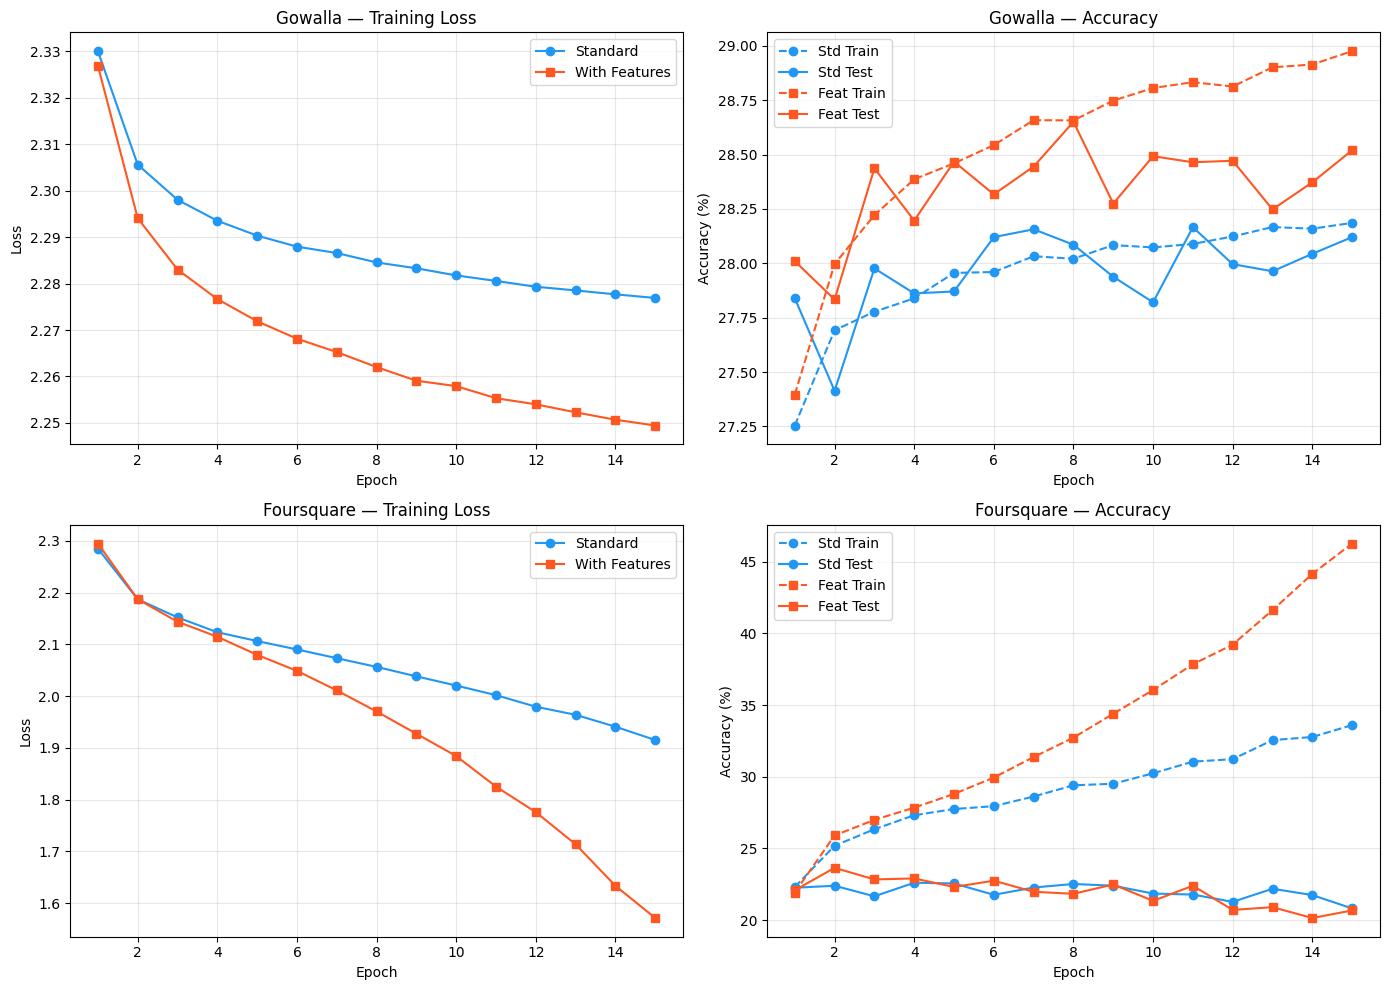

In [22]:
if not LOAD_SAVED:
    # Comparison plots — standard vs feature model per dataset
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs_range = range(1, 16)

    for row, (name, h_std, h_feat) in enumerate([
        ('Gowalla', history_std_gw, history_feat_gw),
        ('Foursquare', history_std_fs, history_feat_fs)
    ]):
        # Loss
        axes[row, 0].plot(epochs_range, h_std['loss'], 'o-', label='Standard', color='#2196F3')
        axes[row, 0].plot(epochs_range, h_feat['loss'], 's-', label='With Features', color='#FF5722')
        axes[row, 0].set_xlabel('Epoch')
        axes[row, 0].set_ylabel('Loss')
        axes[row, 0].set_title(f'{name} — Training Loss')
        axes[row, 0].legend()
        axes[row, 0].grid(True, alpha=0.3)

        # Accuracy
        axes[row, 1].plot(epochs_range, [a*100 for a in h_std['accuracy']], 'o--', label='Std Train', color='#2196F3')
        axes[row, 1].plot(epochs_range, [a*100 for a in h_std['test_accuracy']], 'o-', label='Std Test', color='#2196F3')
        axes[row, 1].plot(epochs_range, [a*100 for a in h_feat['accuracy']], 's--', label='Feat Train', color='#FF5722')
        axes[row, 1].plot(epochs_range, [a*100 for a in h_feat['test_accuracy']], 's-', label='Feat Test', color='#FF5722')
        axes[row, 1].set_xlabel('Epoch')
        axes[row, 1].set_ylabel('Accuracy (%)')
        axes[row, 1].set_title(f'{name} — Accuracy')
        axes[row, 1].legend()
        axes[row, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [23]:
if not LOAD_SAVED:
    # Summary table
    print("\n" + "=" * 70)
    print("RESULTS SUMMARY (final epoch)")
    print("=" * 70)
    print(f"{'Model':<25} {'Dataset':<12} {'Train Acc':>10} {'Test Acc':>10}")
    print("-" * 57)
    for label, h in [
        ('Standard', history_std_gw),
        ('With Features', history_feat_gw),
    ]:
        print(f"{label:<25} {'Gowalla':<12} {h['accuracy'][-1]*100:>9.1f}% {h['test_accuracy'][-1]*100:>9.1f}%")
    for label, h in [
        ('Standard', history_std_fs),
        ('With Features', history_feat_fs),
    ]:
        print(f"{label:<25} {'Foursquare':<12} {h['accuracy'][-1]*100:>9.1f}% {h['test_accuracy'][-1]*100:>9.1f}%")


RESULTS SUMMARY (final epoch)
Model                     Dataset       Train Acc   Test Acc
---------------------------------------------------------
Standard                  Gowalla           28.2%      28.1%
With Features             Gowalla           29.0%      28.5%
Standard                  Foursquare        33.6%      20.8%
With Features             Foursquare        46.3%      20.7%


In [24]:
if not LOAD_SAVED:
    # Save results
    results_to_save = {
        "gowalla_standard": {"history": history_std_gw},
        "gowalla_features": {"history": history_feat_gw},
        "foursquare_standard": {"history": history_std_fs},
        "foursquare_features": {"history": history_feat_fs},
    }
    with open('results_clean.pkl', 'wb') as f:
        pickle.dump(results_to_save, f)
    print("Saved training results to results_clean.pkl")

Saved training results to results_clean.pkl


In [25]:
if LOAD_SAVED:
    with open('results_clean.pkl', 'rb') as f:
        saved = pickle.load(f)

    history_std_gw = saved['gowalla_standard']['history']
    history_feat_gw = saved['gowalla_features']['history']
    history_std_fs = saved['foursquare_standard']['history']
    history_feat_fs = saved['foursquare_features']['history']

    # Restore attention results if available
    attn_std_gw = saved['gowalla_standard'].get('attention_results')
    attn_feat_gw = saved['gowalla_features'].get('attention_results')
    attn_std_fs = saved['foursquare_standard'].get('attention_results')
    attn_feat_fs = saved['foursquare_features'].get('attention_results')

    print("Loaded saved results.")
    print(f"\n{'Model':<25} {'Dataset':<12} {'Train Acc':>10} {'Test Acc':>10}")
    print("-" * 57)
    for label, h in [
        ('Standard', history_std_gw),
        ('With Features', history_feat_gw),
    ]:
        print(f"{label:<25} {'Gowalla':<12} {h['accuracy'][-1]*100:>9.1f}% {h['test_accuracy'][-1]*100:>9.1f}%")
    for label, h in [
        ('Standard', history_std_fs),
        ('With Features', history_feat_fs),
    ]:
        print(f"{label:<25} {'Foursquare':<12} {h['accuracy'][-1]*100:>9.1f}% {h['test_accuracy'][-1]*100:>9.1f}%")

## 6. Attention Analysis

Extract attention weights from the first transformer layer to understand what the model attends to.

We analyze:
- Attention heatmap for individual examples
- Position-based attention (recency bias)
- Return visits vs true transitions
- High attention vs accuracy correlation
- Standard vs feature model comparison

In [26]:
# Run attention analysis on all 4 models (5000 samples each)
if not LOAD_SAVED or attn_std_gw is None:
    print("Analyzing attention (standard Gowalla)...")
    attn_std_gw = analyze_attention(model_std_gw, test_ds_gw, data_gw['vocab'], data_gw['idx_to_cat'], n_samples=5000)

    print("Analyzing attention (standard Foursquare)...")
    attn_std_fs = analyze_attention(model_std_fs, test_ds_fs, data_fs['vocab'], data_fs['idx_to_cat'], n_samples=5000)

    print("Analyzing attention (feature Gowalla)...")
    attn_feat_gw = analyze_attention(model_feat_gw, test_ds_feat_gw, data_feat_gw['vocab'], data_feat_gw['idx_to_cat'], n_samples=5000)

    print("Analyzing attention (feature Foursquare)...")
    attn_feat_fs = analyze_attention(model_feat_fs, test_ds_feat_fs, data_feat_fs['vocab'], data_feat_fs['idx_to_cat'], n_samples=5000)

    print("Done.")

Analyzing attention (standard Gowalla)...
Analyzing attention (standard Foursquare)...
Analyzing attention (feature Gowalla)...
Analyzing attention (feature Foursquare)...
Done.


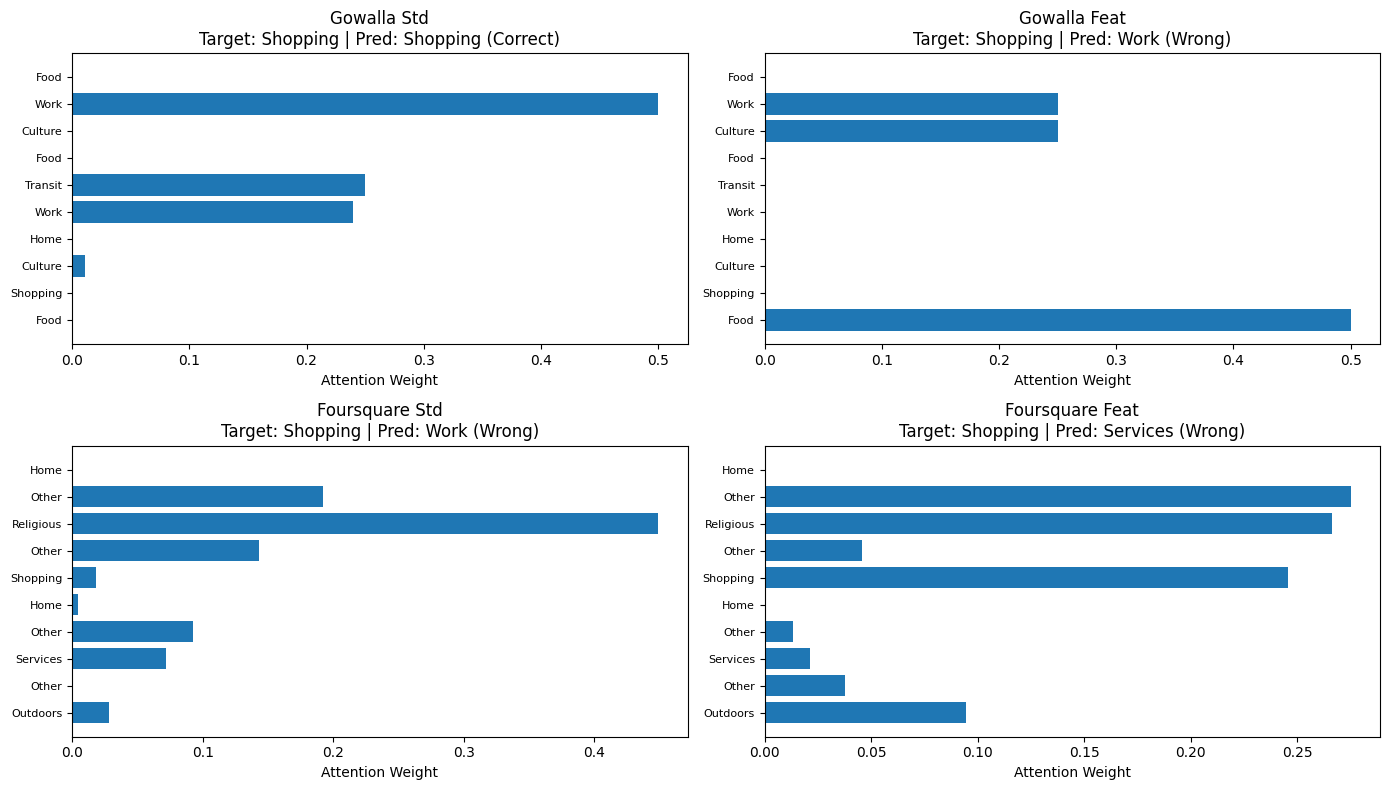

In [27]:
# Attention heatmap — single example visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for col, (name, results) in enumerate([
    ('Gowalla Std', attn_std_gw),
    ('Gowalla Feat', attn_feat_gw)
]):
    # Pick an example with reasonable history length
    example = [r for r in results if len(r['history']) >= 5][10]
    history = example['history']
    attn_vals = example['attn_values']

    axes[0, col].barh(range(len(history)), attn_vals)
    axes[0, col].set_yticks(range(len(history)))
    axes[0, col].set_yticklabels(history, fontsize=8)
    axes[0, col].set_xlabel('Attention Weight')
    correct_str = 'Correct' if example['correct'] else 'Wrong'
    axes[0, col].set_title(f"{name}\nTarget: {example['target']} | Pred: {example['predicted']} ({correct_str})")

for col, (name, results) in enumerate([
    ('Foursquare Std', attn_std_fs),
    ('Foursquare Feat', attn_feat_fs)
]):
    example = [r for r in results if len(r['history']) >= 5][0]
    history = example['history']
    attn_vals = example['attn_values']

    axes[1, col].barh(range(len(history)), attn_vals)
    axes[1, col].set_yticks(range(len(history)))
    axes[1, col].set_yticklabels(history, fontsize=8)
    axes[1, col].set_xlabel('Attention Weight')
    correct_str = 'Correct' if example['correct'] else 'Wrong'
    axes[1, col].set_title(f"{name}\nTarget: {example['target']} | Pred: {example['predicted']} ({correct_str})")

plt.tight_layout()
plt.show()

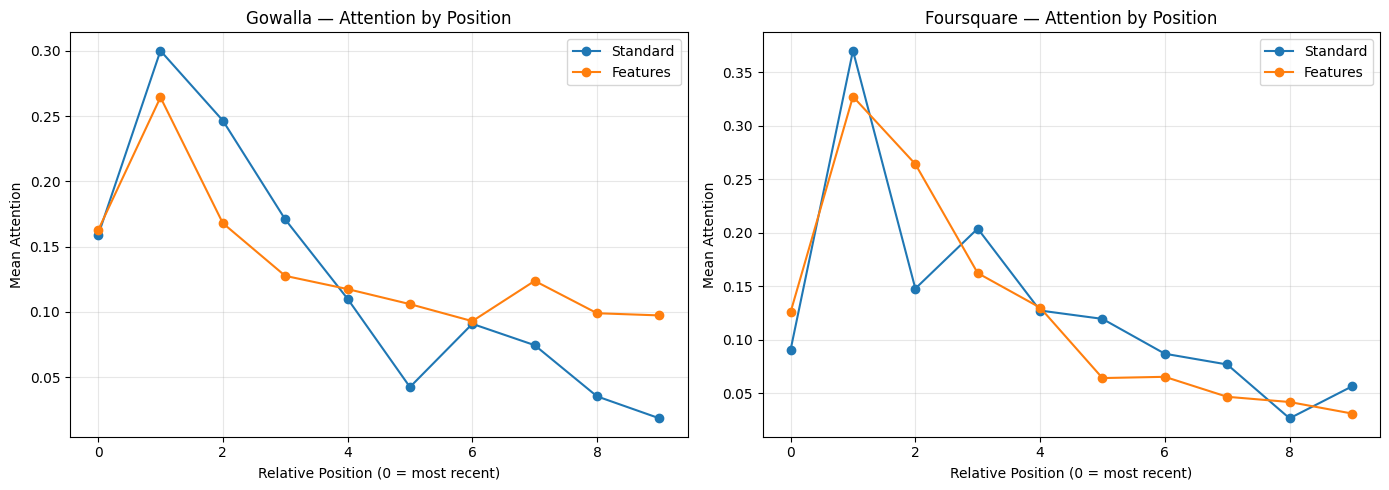

In [28]:
# Attention by position (recency bias)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, results_list) in zip(axes, [
    ('Gowalla', [('Standard', attn_std_gw), ('Features', attn_feat_gw)]),
    ('Foursquare', [('Standard', attn_std_fs), ('Features', attn_feat_fs)])
]):
    for label, results in results_list:
        # Average attention by relative position (0 = most recent)
        max_len = 10
        pos_attn = {i: [] for i in range(max_len)}
        for r in results:
            attn = r['attn_values']
            n = len(attn)
            for j, a in enumerate(attn):
                rel_pos = n - 1 - j  # 0 = most recent
                if rel_pos < max_len:
                    pos_attn[rel_pos].append(a)

        positions = list(range(max_len))
        means = [np.mean(pos_attn[p]) if pos_attn[p] else 0 for p in positions]
        ax.plot(positions, means, 'o-', label=label)

    ax.set_xlabel('Relative Position (0 = most recent)')
    ax.set_ylabel('Mean Attention')
    ax.set_title(f'{name} — Attention by Position')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Return visits vs true transitions
print("Return Visits vs True Transitions")
print("=" * 70)

for name, results in [
    ('Gowalla Standard', attn_std_gw),
    ('Gowalla Features', attn_feat_gw),
    ('Foursquare Standard', attn_std_fs),
    ('Foursquare Features', attn_feat_fs),
]:
    analysis = analyze_by_transition_type(results)
    rv = analysis['return_visits']
    tt = analysis['true_transitions']
    print(f"\n{name}:")
    print(f"  Return visits:    {rv['count']:>4} ({rv['exact_acc']*100:.1f}% accuracy)")
    print(f"  True transitions: {tt['count']:>4} ({tt['exact_acc']*100:.1f}% accuracy)")

Return Visits vs True Transitions

Gowalla Standard:
  Return visits:    2552 (45.1% accuracy)
  True transitions: 2448 (11.4% accuracy)

Gowalla Features:
  Return visits:    2552 (47.1% accuracy)
  True transitions: 2448 (10.7% accuracy)

Foursquare Standard:
  Return visits:    2912 (31.2% accuracy)
  True transitions: 2088 (5.6% accuracy)

Foursquare Features:
  Return visits:    2912 (29.5% accuracy)
  True transitions: 2088 (7.8% accuracy)


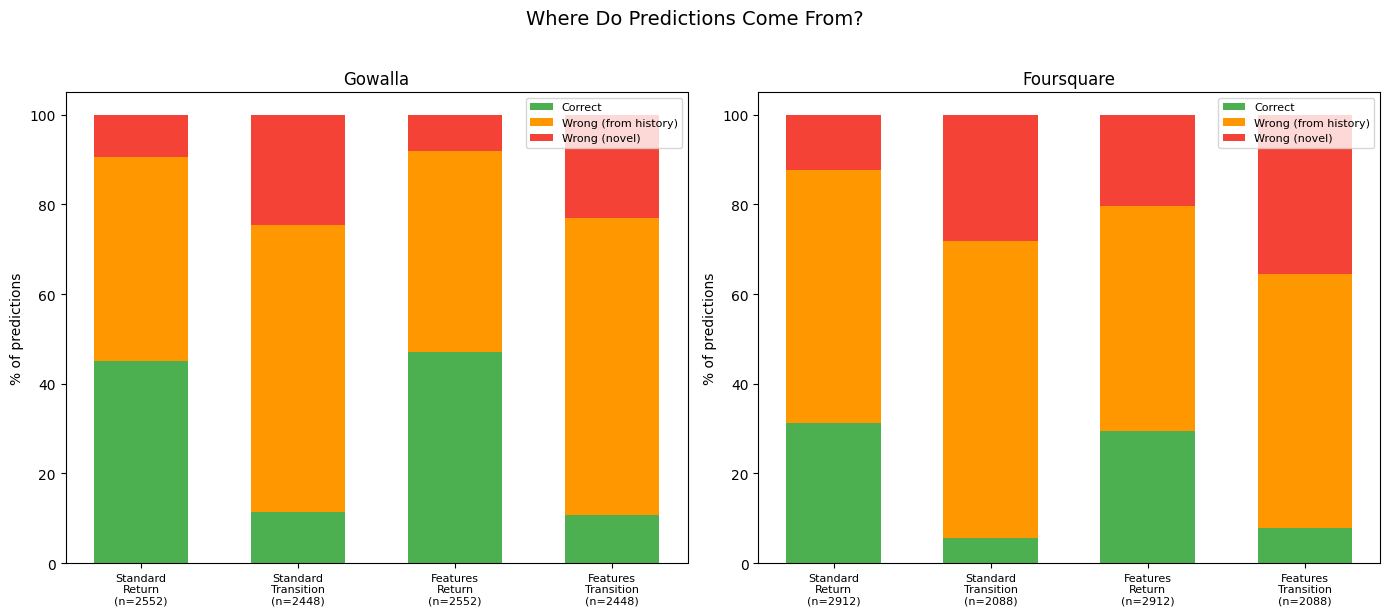

In [30]:
# Prediction source breakdown: where do predictions come from?
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (dataset_name, models) in zip(axes, [
    ('Gowalla', [('Standard', attn_std_gw), ('Features', attn_feat_gw)]),
    ('Foursquare', [('Standard', attn_std_fs), ('Features', attn_feat_fs)]),
]):
    labels = []
    correct_pcts = []
    from_history_pcts = []
    novel_pcts = []

    for model_name, results in models:
        for visit_type in ['Return', 'Transition']:
            if visit_type == 'Return':
                subset = [r for r in results if r['target'] in r['history']]
            else:
                subset = [r for r in results if r['target'] not in r['history']]

            if not subset:
                continue

            correct = sum(1 for r in subset if r['correct'])
            from_hist = sum(1 for r in subset if not r['correct'] and r['predicted'] in r['history'])
            novel = sum(1 for r in subset if not r['correct'] and r['predicted'] not in r['history'])
            n = len(subset)

            labels.append(f'{model_name}\n{visit_type}\n(n={n})')
            correct_pcts.append(correct / n * 100)
            from_history_pcts.append(from_hist / n * 100)
            novel_pcts.append(novel / n * 100)

    x = np.arange(len(labels))
    width = 0.6

    ax.bar(x, correct_pcts, width, label='Correct', color='#4CAF50')
    ax.bar(x, from_history_pcts, width, bottom=correct_pcts, label='Wrong (from history)', color='#FF9800')
    ax.bar(x, novel_pcts, width, bottom=[c + h for c, h in zip(correct_pcts, from_history_pcts)],
           label='Wrong (novel)', color='#F44336')

    ax.set_ylabel('% of predictions')
    ax.set_title(f'{dataset_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=8)
    ax.legend(fontsize=8)
    ax.set_ylim(0, 105)

plt.suptitle('Where Do Predictions Come From?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [31]:
# High attention vs accuracy
print("Attention Statistics")
print("=" * 60)

for name, results in [
    ('Gowalla Standard', attn_std_gw),
    ('Gowalla Features', attn_feat_gw),
    ('Foursquare Standard', attn_std_fs),
    ('Foursquare Features', attn_feat_fs),
]:
    stats = get_attention_stats(results)
    overall_acc = np.mean([r['correct'] for r in results])

    # High-attention correct vs low-attention correct
    high_attn = [r for r in results if max(r['attn_values']) > stats['max_attn']]
    low_attn = [r for r in results if max(r['attn_values']) <= stats['max_attn']]
    high_acc = np.mean([r['correct'] for r in high_attn]) if high_attn else 0
    low_acc = np.mean([r['correct'] for r in low_attn]) if low_attn else 0

    print(f"\n{name}:")
    print(f"  Overall accuracy: {overall_acc*100:.1f}%")
    print(f"  Max attention (mean): {stats['max_attn']:.3f}")
    print(f"  Attention spread (std): {stats['attn_spread']:.3f}")
    print(f"  High-attn accuracy: {high_acc*100:.1f}% ({len(high_attn)} samples)")
    print(f"  Low-attn accuracy:  {low_acc*100:.1f}% ({len(low_attn)} samples)")

Attention Statistics

Gowalla Standard:
  Overall accuracy: 28.6%
  Max attention (mean): 0.413
  Attention spread (std): 0.150
  High-attn accuracy: 29.7% (3037 samples)
  Low-attn accuracy:  26.9% (1963 samples)

Gowalla Features:
  Overall accuracy: 29.3%
  Max attention (mean): 0.561
  Attention spread (std): 0.199
  High-attn accuracy: 28.3% (1931 samples)
  Low-attn accuracy:  29.9% (3069 samples)

Foursquare Standard:
  Overall accuracy: 20.5%
  Max attention (mean): 0.491
  Attention spread (std): 0.182
  High-attn accuracy: 19.4% (2309 samples)
  Low-attn accuracy:  21.5% (2691 samples)

Foursquare Features:
  Overall accuracy: 20.5%
  Max attention (mean): 0.458
  Attention spread (std): 0.158
  High-attn accuracy: 19.5% (2402 samples)
  Low-attn accuracy:  21.4% (2598 samples)


In [37]:
# Deep dive: WHY does high attention hurt in the feature model?
# Split by: (1) return vs transition, (2) whether max-attn position = most recent

print("High vs Low Attention — Breakdown")
print("=" * 75)

for name, results in [
    ('Gowalla Standard', attn_std_gw),
    ('Gowalla Features', attn_feat_gw),
    ('Foursquare Standard', attn_std_fs),
    ('Foursquare Features', attn_feat_fs),
]:
    stats = get_attention_stats(results)
    threshold = stats['max_attn']

    high = [r for r in results if max(r['attn_values']) > threshold]
    low = [r for r in results if max(r['attn_values']) <= threshold]

    print(f"\n{name} (threshold: {threshold:.3f})")
    print(f"  {'':30s} {'High-attn':>12} {'Low-attn':>12}")
    print(f"  {'-'*54}")

    for label, subset_h, subset_l in [
        ('All', high, low),
    ]:
        acc_h = np.mean([r['correct'] for r in subset_h]) * 100 if subset_h else 0
        acc_l = np.mean([r['correct'] for r in subset_l]) * 100 if subset_l else 0
        print(f"  {'Overall accuracy':<30s} {acc_h:>10.1f}%  {acc_l:>10.1f}%")

    # Return visits vs transitions in each group
    for group_name, group in [('High-attn', high), ('Low-attn', low)]:
        rv = [r for r in group if r['target'] in r['history']]
        tt = [r for r in group if r['target'] not in r['history']]
        rv_pct = len(rv) / len(group) * 100 if group else 0
        rv_acc = np.mean([r['correct'] for r in rv]) * 100 if rv else 0
        tt_acc = np.mean([r['correct'] for r in tt]) * 100 if tt else 0
        print(f"  {group_name}: {rv_pct:.0f}% returns (rv_acc={rv_acc:.1f}%, tt_acc={tt_acc:.1f}%)")

    # Is max attention on the most recent position?
    high_on_recent = [r for r in high if np.argmax(r['attn_values']) == len(r['attn_values']) - 1]
    low_on_recent = [r for r in low if np.argmax(r['attn_values']) == len(r['attn_values']) - 1]
    print(f"  Max-attn on most recent: high={len(high_on_recent)/len(high)*100:.0f}%, low={len(low_on_recent)/len(low)*100:.0f}%")

    # When wrong + high attn: does model predict the max-attended category?
    wrong_high = [r for r in high if not r['correct']]
    predicts_fixated = 0
    for r in wrong_high:
        max_pos = np.argmax(r['attn_values'])
        fixated_cat = r['history'][max_pos]
        if r['predicted'] == fixated_cat:
            predicts_fixated += 1
    if wrong_high:
        print(f"  Wrong + high-attn: predicts fixated category {predicts_fixated/len(wrong_high)*100:.0f}% of time")

High vs Low Attention — Breakdown

Gowalla Standard (threshold: 0.413)
                                    High-attn     Low-attn
  ------------------------------------------------------
  Overall accuracy                     29.7%        26.9%
  High-attn: 44% returns (rv_acc=49.7%, tt_acc=13.9%)
  Low-attn: 62% returns (rv_acc=40.0%, tt_acc=5.6%)
  Max-attn on most recent: high=15%, low=0%
  Wrong + high-attn: predicts fixated category 33% of time

Gowalla Features (threshold: 0.561)
                                    High-attn     Low-attn
  ------------------------------------------------------
  Overall accuracy                     28.3%        29.9%
  High-attn: 39% returns (rv_acc=48.0%, tt_acc=15.7%)
  Low-attn: 58% returns (rv_acc=46.8%, tt_acc=6.2%)
  Max-attn on most recent: high=20%, low=2%
  Wrong + high-attn: predicts fixated category 14% of time

Foursquare Standard (threshold: 0.491)
                                    High-attn     Low-attn
  -------------------------

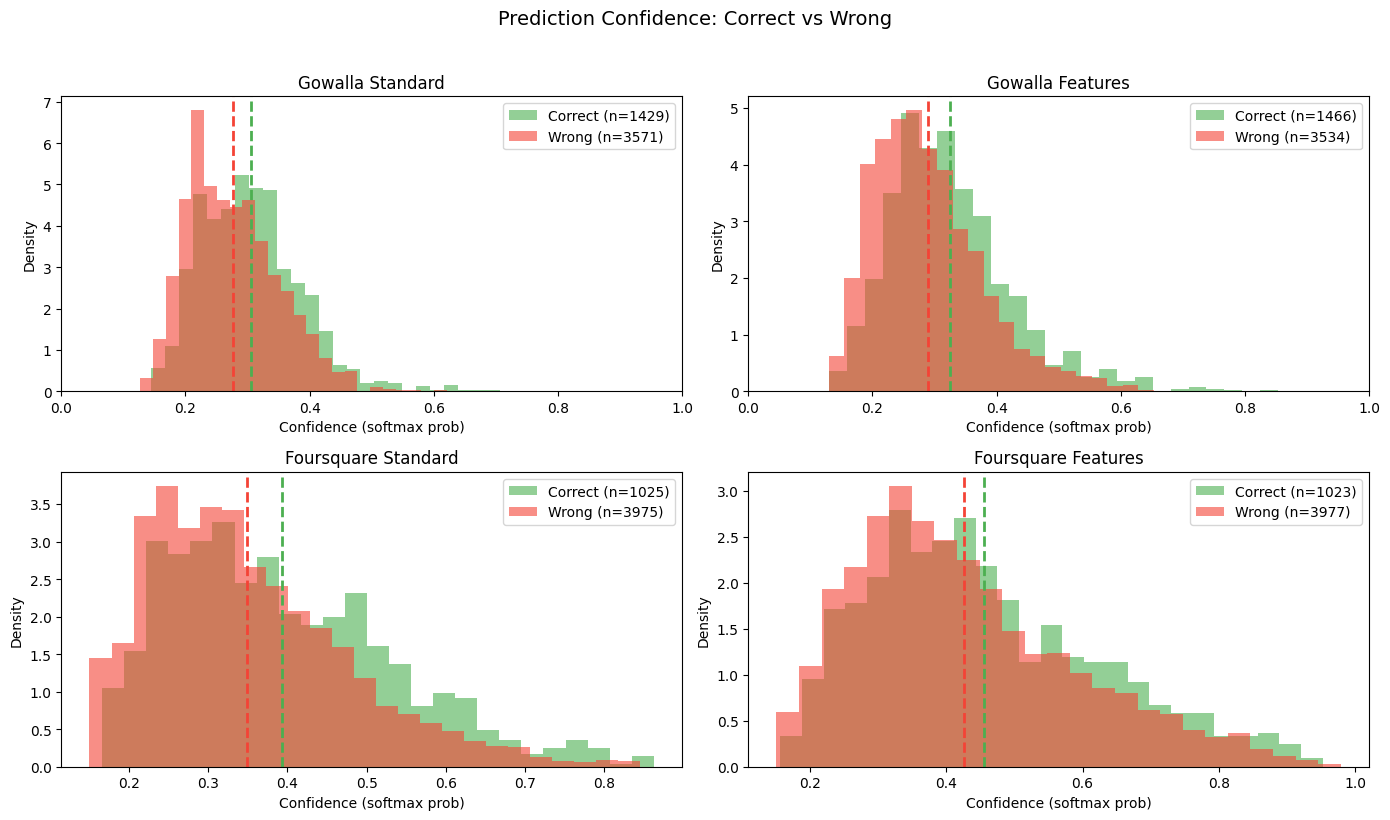

In [32]:
# Prediction confidence distribution: correct vs wrong (normalized)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for row, (name, results) in enumerate([
    ('Gowalla Standard', attn_std_gw),
    ('Gowalla Features', attn_feat_gw),
]):
    conf_correct = [r['confidence'] for r in results if r['correct']]
    conf_wrong = [r['confidence'] for r in results if not r['correct']]

    axes[0, row].hist(conf_correct, bins=25, alpha=0.6, density=True, label=f'Correct (n={len(conf_correct)})', color='#4CAF50')
    axes[0, row].hist(conf_wrong, bins=25, alpha=0.6, density=True, label=f'Wrong (n={len(conf_wrong)})', color='#F44336')
    axes[0, row].axvline(np.mean(conf_correct), color='#4CAF50', linestyle='--', linewidth=2)
    axes[0, row].axvline(np.mean(conf_wrong), color='#F44336', linestyle='--', linewidth=2)
    axes[0, row].set_xlabel('Confidence (softmax prob)')
    axes[0, row].set_ylabel('Density')
    axes[0, row].set_xlim((0,1))
    axes[0, row].set_title(f'{name}')
    axes[0, row].legend()

for row, (name, results) in enumerate([
    ('Foursquare Standard', attn_std_fs),
    ('Foursquare Features', attn_feat_fs),
]):
    conf_correct = [r['confidence'] for r in results if r['correct']]
    conf_wrong = [r['confidence'] for r in results if not r['correct']]

    axes[1, row].hist(conf_correct, bins=25, alpha=0.6, density=True, label=f'Correct (n={len(conf_correct)})', color='#4CAF50')
    axes[1, row].hist(conf_wrong, bins=25, alpha=0.6, density=True, label=f'Wrong (n={len(conf_wrong)})', color='#F44336')
    axes[1, row].axvline(np.mean(conf_correct), color='#4CAF50', linestyle='--', linewidth=2)
    axes[1, row].axvline(np.mean(conf_wrong), color='#F44336', linestyle='--', linewidth=2)
    axes[1, row].set_xlabel('Confidence (softmax prob)')
    axes[1, row].set_ylabel('Density')
    axes[1, row].set_title(f'{name}')
    axes[1, row].legend()

plt.suptitle('Prediction Confidence: Correct vs Wrong', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

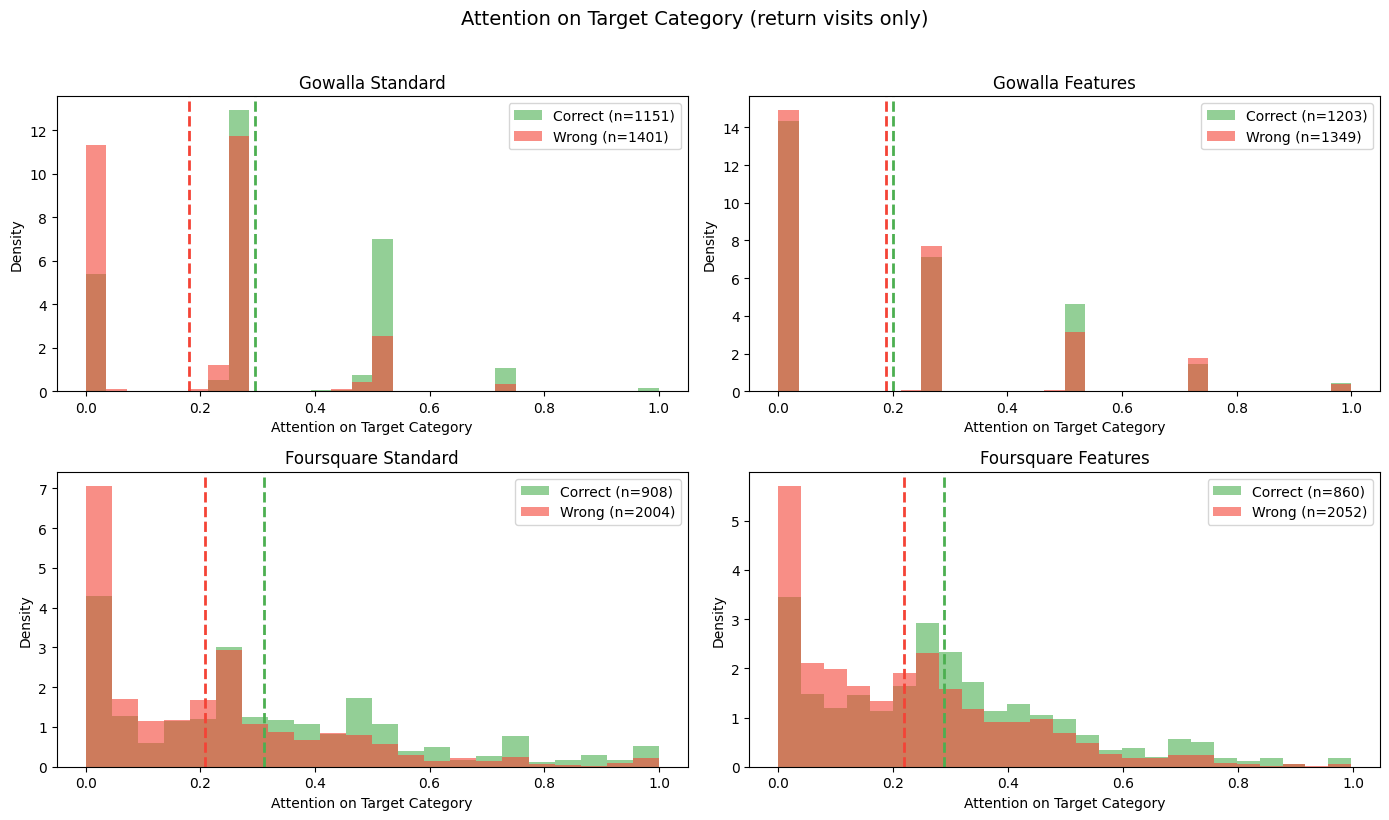

In [33]:
# Attention on target category: correct vs wrong
# For samples where target appears in history, how much attention goes to those positions?
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for row, (name, results) in enumerate([
    ('Gowalla Standard', attn_std_gw),
    ('Gowalla Features', attn_feat_gw),
]):
    attn_on_target_correct = []
    attn_on_target_wrong = []
    for r in results:
        target = r['target']
        if target not in r['history']:
            continue
        # Sum attention on all positions matching target
        total_attn = sum(a for cat, a in r['attention'].items() if cat == target)
        if r['correct']:
            attn_on_target_correct.append(total_attn)
        else:
            attn_on_target_wrong.append(total_attn)

    if attn_on_target_correct and attn_on_target_wrong:
        _, bin_edges = np.histogram(attn_on_target_correct + attn_on_target_wrong, bins='auto')
        axes[0, row].hist(attn_on_target_correct, bins=bin_edges, alpha=0.6, density=True,
                          label=f'Correct (n={len(attn_on_target_correct)})', color='#4CAF50')
        axes[0, row].hist(attn_on_target_wrong, bins=bin_edges, alpha=0.6, density=True,
                          label=f'Wrong (n={len(attn_on_target_wrong)})', color='#F44336')
        axes[0, row].axvline(np.mean(attn_on_target_correct), color='#4CAF50', linestyle='--', linewidth=2)
        axes[0, row].axvline(np.mean(attn_on_target_wrong), color='#F44336', linestyle='--', linewidth=2)
    axes[0, row].set_xlabel('Attention on Target Category')
    axes[0, row].set_ylabel('Density')
    axes[0, row].set_title(f'{name}')
    axes[0, row].legend()

for row, (name, results) in enumerate([
    ('Foursquare Standard', attn_std_fs),
    ('Foursquare Features', attn_feat_fs),
]):
    attn_on_target_correct = []
    attn_on_target_wrong = []
    for r in results:
        target = r['target']
        if target not in r['history']:
            continue
        total_attn = sum(a for cat, a in r['attention'].items() if cat == target)
        if r['correct']:
            attn_on_target_correct.append(total_attn)
        else:
            attn_on_target_wrong.append(total_attn)

    if attn_on_target_correct and attn_on_target_wrong:
        _, bin_edges = np.histogram(attn_on_target_correct + attn_on_target_wrong, bins='auto')
        axes[1, row].hist(attn_on_target_correct, bins=bin_edges, alpha=0.6, density=True,
                          label=f'Correct (n={len(attn_on_target_correct)})', color='#4CAF50')
        axes[1, row].hist(attn_on_target_wrong, bins=bin_edges, alpha=0.6, density=True,
                          label=f'Wrong (n={len(attn_on_target_wrong)})', color='#F44336')
        axes[1, row].axvline(np.mean(attn_on_target_correct), color='#4CAF50', linestyle='--', linewidth=2)
        axes[1, row].axvline(np.mean(attn_on_target_wrong), color='#F44336', linestyle='--', linewidth=2)
    axes[1, row].set_xlabel('Attention on Target Category')
    axes[1, row].set_ylabel('Density')
    axes[1, row].set_title(f'{name}')
    axes[1, row].legend()

plt.suptitle('Attention on Target Category (return visits only)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

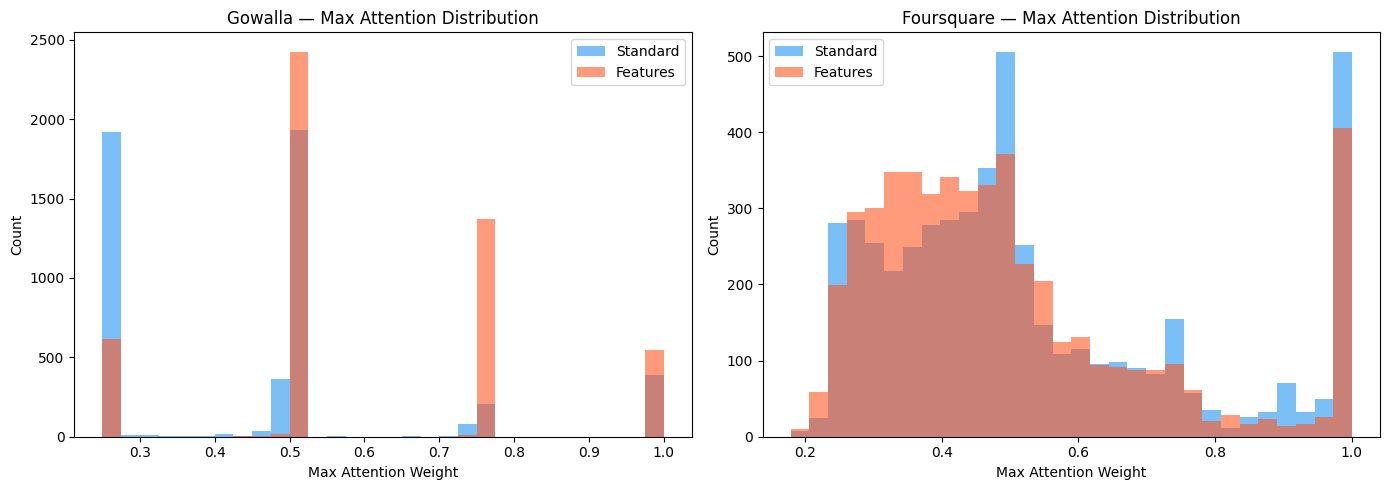

In [34]:
# Compare attention patterns: standard vs feature model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, std_results, feat_results) in zip(axes, [
    ('Gowalla', attn_std_gw, attn_feat_gw),
    ('Foursquare', attn_std_fs, attn_feat_fs)
]):
    std_max = [max(r['attn_values']) for r in std_results]
    feat_max = [max(r['attn_values']) for r in feat_results]

    ax.hist(std_max, bins=30, alpha=0.6, label='Standard', color='#2196F3')
    ax.hist(feat_max, bins=30, alpha=0.6, label='Features', color='#FF5722')
    ax.set_xlabel('Max Attention Weight')
    ax.set_ylabel('Count')
    ax.set_title(f'{name} — Max Attention Distribution')
    ax.legend()

plt.tight_layout()
plt.show()

In [35]:
# Save attention results alongside training histories
if not LOAD_SAVED:
    results_to_save = {
        "gowalla_standard": {"history": history_std_gw, "attention_results": attn_std_gw},
        "gowalla_features": {"history": history_feat_gw, "attention_results": attn_feat_gw},
        "foursquare_standard": {"history": history_std_fs, "attention_results": attn_std_fs},
        "foursquare_features": {"history": history_feat_fs, "attention_results": attn_feat_fs},
    }
    with open('results_clean.pkl', 'wb') as f:
        pickle.dump(results_to_save, f)
    print("Saved all results (training + attention) to results_clean.pkl")

Saved all results (training + attention) to results_clean.pkl


## 7. Summary

### Prediction Accuracy

| Model | Dataset | Train Acc | Test Acc | Baselines |
|-------|---------|-----------|----------|-----------|
| Standard | Gowalla (18 classes) | 28.2% | 28.1% | Random: 5.6%, Most-freq: 21.9% |
| **With Features** | **Gowalla** | **29.0%** | **28.5%** | |
| Standard | Foursquare (15 classes) | 33.6% | 20.8% | Random: 6.7%, Most-freq: 15.9% |
| With Features | Foursquare | 46.3% | 20.7% | |

- Both models substantially beat baselines on both datasets.
- The feature model provides a small improvement on Gowalla (+0.4pp test), where data is plentiful (66K trajectories, 1,071 users).
- On Foursquare (2,256 trajectories, 129 users), the feature model severely overfits (46.3% train vs 20.7% test) — the small dataset cannot support the additional feature parameters.
- Gowalla generalizes well: train and test accuracy are nearly identical, indicating no overfitting.

### Return Visits vs True Transitions

| Model | Return Visit Acc | True Transition Acc |
|-------|-----------------|-------------------|
| Gowalla Standard | 45.1% | 11.4% |
| Gowalla Features | 47.1% | 10.7% |
| Foursquare Standard | 31.2% | 5.6% |
| Foursquare Features | 29.5% | 7.8% |

- **Return visits** (target category appeared in history) are 3-5x easier to predict than **true transitions** (target is new).
- About half of test samples are return visits, which dominate overall accuracy.
- The feature model slightly improves return-visit accuracy on Gowalla (+2pp) but not on Foursquare.

### Attention Analysis

**Recency bias**: Both models attend most to the most recent positions in the trajectory.

**Simpson's paradox in attention-accuracy relationship**: At first glance, high-attention samples appear to have *lower* accuracy than low-attention samples in 3 of 4 models. However, this is a composition effect:

- High-attention samples contain more **true transitions** (only 39-45% are return visits).
- Low-attention samples contain more **return visits** (58-71%), which are inherently easier.
- **Within each transition type, high attention is consistently better**:

| Model | Returns: High-attn | Returns: Low-attn | Transitions: High-attn | Transitions: Low-attn |
|-------|-------------------|-------------------|----------------------|---------------------|
| GW Standard | **49.7%** | 40.0% | **13.9%** | 5.6% |
| GW Features | **48.0%** | 46.8% | **15.7%** | 6.2% |
| FS Standard | **35.5%** | 28.9% | **7.1%** | 3.1% |
| FS Features | **31.6%** | 28.3% | **9.4%** | 5.0% |

The model concentrates attention when it faces harder cases (true transitions), which drags down the high-attention group's overall accuracy despite it being the better strategy within each case type.

**Standard vs feature model attention mechanisms**:
- The standard model uses attention as a **lookup**: when wrong with high attention, it predicts the most-attended category 33% of the time (Gowalla) — it copies what it stares at.
- The feature model uses attention as **context reading**: it only predicts the most-attended category 14% of the time (Gowalla). Instead, it focuses on a position to read its temporal/spatial features (hour, time gap, distance) and uses that context to predict a *different* category.
- The feature model has sharper attention overall (mean max attention: 0.561 vs 0.413 on Gowalla), showing it has learned to use features to identify which positions are most informative.